Epoch [0/1000] Step [0/13] Loss D: 1.3328 Loss G: 1.7037
Epoch [1/1000] Step [0/13] Loss D: 0.4001 Loss G: 4.4896
Epoch [2/1000] Step [0/13] Loss D: 0.3565 Loss G: 6.1313
Epoch [3/1000] Step [0/13] Loss D: 0.3486 Loss G: 5.4936
Epoch [4/1000] Step [0/13] Loss D: 0.3906 Loss G: 6.2183
Epoch [5/1000] Step [0/13] Loss D: 0.3519 Loss G: 4.8815
Epoch [6/1000] Step [0/13] Loss D: 0.3496 Loss G: 5.8127
Epoch [7/1000] Step [0/13] Loss D: 0.4101 Loss G: 4.3992
Epoch [8/1000] Step [0/13] Loss D: 0.4143 Loss G: 5.1164
Epoch [9/1000] Step [0/13] Loss D: 0.4663 Loss G: 4.5263
Epoch [10/1000] Step [0/13] Loss D: 0.7353 Loss G: 4.4084
Epoch [11/1000] Step [0/13] Loss D: 0.4148 Loss G: 4.0458
Epoch [12/1000] Step [0/13] Loss D: 0.7309 Loss G: 6.9983
Epoch [13/1000] Step [0/13] Loss D: 0.5676 Loss G: 3.1218
Epoch [14/1000] Step [0/13] Loss D: 0.9902 Loss G: 7.2321
Epoch [15/1000] Step [0/13] Loss D: 1.2058 Loss G: 3.1448
Epoch [16/1000] Step [0/13] Loss D: 0.3926 Loss G: 4.1661
Epoch [17/1000] Step [0/

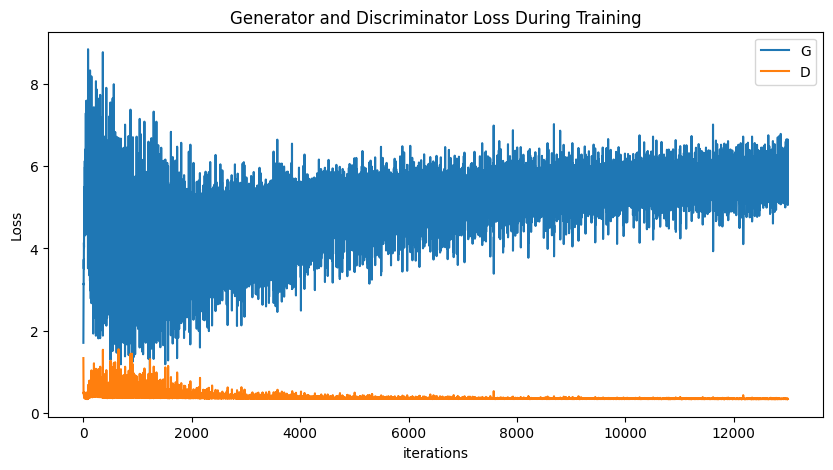

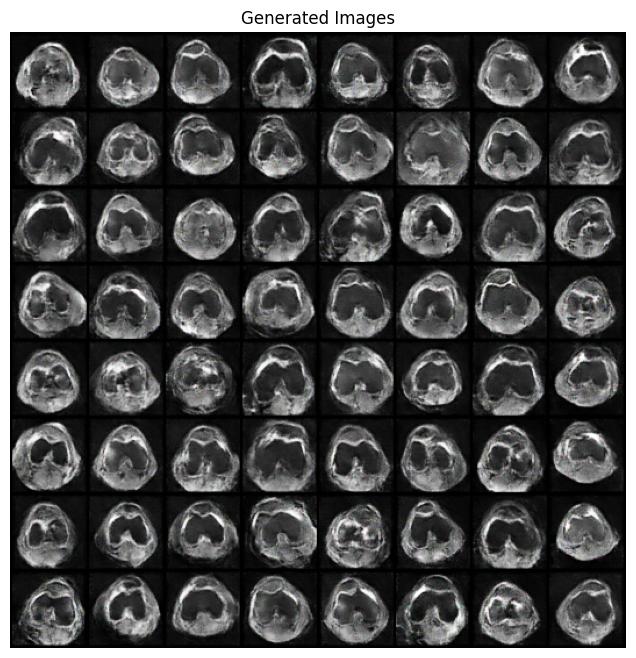

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

batch_size = 128
image_size = 64
nz = 100       # Size of the latent vector (noise)
nc = 3         # Number of channels (1 for grayscale, 3 for RGB)
ngf = 64       # Generator feature map size
ndf = 64       # Discriminator feature map size
num_epochs = 1000
lr = 0.0001
beta1 = 0.5    # Beta1 for Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to match GAN input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize if needed
])

dataset = CustomDataset(root_dir='D:/project/mrnetdata/train/1/axial', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 0.9
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.9))

img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] Loss D: {errD.item():.4f} Loss G: {errG.item():.4f}")

    # Generate fake images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Display generated images from fixed_noise
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()



In [2]:
images=370
save_dir = "D:/project/generated mrnet data/axial"
os.makedirs(save_dir, exist_ok=True) 


for i in range(images):
    with torch.no_grad():
        z = torch.randn(16, nz, 1, 1, device=device)
        gen_imgs = netG(z).cpu()

        for j, img in enumerate(gen_imgs):
            img = img.permute(1, 2, 0).numpy() 
            img = (img + 1) / 2.0 
            img_path = os.path.join(save_dir, f"img_{((i+1)*(j+1))+1}.png")
            plt.imsave(img_path, img, cmap='gray')  